In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
# 학습 or 실행 도중 오류가 나서 session이 안닫혔을 경우
# tf.reset_default_graph ()

# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module6

    -Part 03. RNN 개요 및 구현
    
        01. Case Study : Vanilla char-RNN

##### Recurrent Neural Network ( 순환신경망 )

$$ h_t = f_W (h_{t-1},x_t) \;:\; h_t\; =\; tanh\,(\,h_{t-1} W_h + x_t W_x = b\,) $$

    Input, Hidden Layer
$$ h_t\; =\; tanh\,(\,W_{hh} h_{t-1} + W_{xh} x_t = b\,) $$

$$ W_{hh} : h_{t-1} -> h_t $$

$$ W_{xh} : x -> h_t $$

$$ x -> W\_xh -> hidden\;layer -> W\_hy -> y $$

    Output Layer
$$ y_t = W_{hy}h_t $$

    vanilla RNN 
    - 이전 시점의 결과를 영향으로 주는 h_t-1 * W_h를 일정하게 주는 방법

    - hidden layer에서 input 데이터의 특성을 살리지만 축약 시키는 기법은 
      PCA와 같다 (차원을 축속하는 것)
    
$$  손실 함수 : y - \hat{y} $$

    - 이 손실함수를 최소로 하는 w를 구하는게 Neural Network
    - 이 w는 초기값을 어떻게 주느냐에 따라 달라진다. 따라서 전체적으로 변경
    - 즉, 추정값 y에는 모든 w값이 반영되어 있다.
    
$$ w_{t+1} = w_t + \alpha \vartriangle w $$

    w값 업데이트 방법 : online, batch, minibatch
    - online : 모든 데이터를 한번에 업데이트 (반응이 예민)
    - minibatch : t시점의 w를 통해 t-1시점의 w를 구함
    - hidden layer -> RNN 에서는 cell
    - multi layer RNN : cell(hideen)을 추가하는 것 (cell이 위,중간 두겹)
    - convolution RNN : cell 아랫단에 convolution층을 붙인 것 (중간, 아래

    output이 여러개면 error을 종합하는 error함수를 만들어서 back
    역전파 : wx와 h, 2가지 방법이 있는데 각각의 모수에 대해 미분을 적용함

https://gist.github.com/karpathy/d4dee566867f8291f086 참고

In [50]:
# smaple text
sample = 'hihello'

char_set = list(set(sample)) # id -> char ['i', 'l', 'e', 'o', 'h']
# set함수는 char를 한글자한글자 분리한 후 unique 때림
char_dic = {w:i for i, w in enumerate(char_set)}
# word2vec과 같이 사전 생성 후 key와 value를 뒤집어 줌

x_str = sample[:-1] # input인데 마지막게 들어가면 안되므로
y_str = sample[1:] # cell마다의 output이므로 두번째부터

data_dim = len(char_set)
timesteps = len(y_str) # 과거 데이터 개념
num_class = len(char_set)

print(x_str, y_str)

hihell ihello


In [25]:
sample, set(sample)

('hihello', {'e', 'h', 'i', 'l', 'o'})

In [13]:
char_set, char_dic

(['o', 'i', 'h', 'e', 'l'], {'o': 0, 'i': 1, 'h': 2, 'e': 3, 'l': 4})

##### rmsprop 실제로 시계열과 같은 변동산(분산)을 가지고 있는 데이터를 분석하기 적합
##### 분류는 보통 Adam을 많이 씀

tensorflow.org -> API -> keras

    LSTM -> 주로 사용
    LSTM Cell -> 사용할 cell과 layer를 재구성할 떄 사용
    GRU -> 주로 사용
    RNN
    Simple RNN -> vanilla RNN
    동적 RNN

google playground

tensorboard

In [58]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation, LSTM, SimpleRNN
from keras.utils import np_utils

import os

# brew intrall graphviz
# pip3 install graphviz
# pip3 install pydot-ng
from keras.utils.vis_utils import plot_model

x = [char_dic[c] for c in x_str] # char to index
y = [char_dic[c] for c in y_str] # char to index

# One-hot encoding
x = np_utils.to_categorical(x, num_classes = num_class)
# keras의 categorical을 사용해도됨
# reshape X to be [samples, time steps, features]
x = np.reshape(x, (-1, len(x), data_dim))
# -1 : data(단어) 갯수 / 글자별 one-hot 후 len / 단어를 글자별로 분리한 수
# 위,아래 방향으로 들어가도록 하는 차원 최적화
print(x.shape)

y = np_utils.to_categorical(y, num_classes = num_class)
# time steps
y = np.reshape(y, (-1, len(y), data_dim))
# y = np.reshape(y, (-1, len(y), data_dim))
print(y.shape)

model = Sequential()
# default로 activation = tanh가 들어가있음
# 그러나 Dense층에는 지정을 해주어야함
model.add(SimpleRNN(num_class, input_shape = (timesteps, data_dim),
              return_sequences = True))
# batch방식의 사이즈 : (7,100,5) -> (과거일자, 행, 열)
# LSTM은 SimpleRNN자리만 바꿔주면 됨
model.add(TimeDistributed(Dense(num_class)))
# model.add(TimeDistributed(Dense(num_classes))) -> 분포를 떨어트리는 과정
model.add(Activation('softmax'))
model.summary()

# Store model graph in png
# (Error occurs on i python interactive shell)
# plot_model(model, to_file = os.path.basename(__file__) + '.png', show)

model.compile(loss='categorical_crossentropy', optimizer = 'Adam',
              metrics = ['accuracy'])
# rmsprop 실제로 시계열과 같은 변동산(분산)을 가지고 있는 데이터를 분석하기 적합
# 분류는 보통 Adam을 많이 씀
model.fit(x, y, epochs = 5, batch_size = 1)

predictions = model.predict(x, verbose = 0)

# label을 찾아오는 과정
for i, prediction in enumerate(predictions):
    print(prediction)
    x_index = np.argmax(x[i], axis = 1)
    x_str = [char_set[j] for j in x_index]
    print(x_index, ''.join(x_str))
    
    index = np.argmax(prediction, axis = 1)
    result = [char_set[j] for j in index]
    print(index, ''.join(result))

(1, 6, 5)
(1, 6, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_31 (SimpleRNN)    (None, 6, 5)              55        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 6, 5)              30        
_________________________________________________________________
activation_16 (Activation)   (None, 6, 5)              0         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1/1 [==============================] - 1s 566ms/step - loss: 1.4927 - acc: 0.1667
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4877 - acc: 0.1667
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 1.4826 - acc: 0.1667
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 1.4776 - acc: 0.1667
Epoch 5/5
1/1 [=============

# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module6

    -Part 04. RNN 적용 사례
    
        01. LSTM

데이터 분석 과정

    1. sort
    2. 모델 설계
    3. 단위 표준화
    4. reshape (3차원으로)
    5. 훈련 - 과거(train), 최근(test)
    6. 표준화되어 나온 결과값 원 데이터로 다시 전환
    7. RMSE, MSE
    8. 시각화로 확인 (같은 패턴을 보이는지)

##### 주식데이터 분석

    종가를 예측하고 싶을때 종가가 있는 열까지 포함해서 training
    출력에서만 y를 종가로 지정
    x에도 종가가 있고, y에도 종가가 있음

In [63]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)

import matplotlib.pyplot as plt

# train Parameters
seq_length = 7 # cell갯수
data_dim = 5 # 한개의 raw에 들어있넌 데이터의 length
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

xy1 = np.loadtxt('data-02-stock_daily.csv', delimiter = ',')
xy1 = xy1[::-1] # reverse order (chronically ordered)
# 그냥 sort함수를 써도됨 (과거데이터가 위로, 최근일수록 밑으로)
min1 = np.min(xy1, 0)
max1 = np.max(xy1, 0) # 뒤에 0은 axis를 뜻함 (열 별로)

xy = (xy1-min1)/(max1-min1)

# y는 종가데이터가 들어가야 함
xy[1]
x = xy
y0 = xy[:, -1] # -> 벡터로 들어감 (이건 필요없고 밑에거만 있으면 됨)
y = xy[:, [-1]] # (n, 1)로 들어감

# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length] # 0,1,2,3,4,5,6
    _y = y[i + seq_length] # Next close price 7
    print(_x, "->", _y)
    dataX.append(_x)
    # i일꺼 데이터가 한줄에 들어가게
    # list 안에 list의 형태로 들어감
    dataY.append(_y)
dataX[0]

# train/test split
train_size = int(len(dataY) * 0.7) # 이렇게 해야 순서 안바뀌고 선택
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

model13 = tf.keras.models.Sequential()
model13.add(tf.keras.layers.LSTM(10, input_shape = (7,5)))
model13.add(tf.keras.layers.Dense(1)) # 예측값 1개 이므로

# optimizer = tf.train.AdamOptimizer(Learning_rate)
optimizer = tf.train.AdamOptimizer(0.01)
model13.compile(loss = 'mean_squared_error',
               # optimizer = 'adam',
               optimizer = optimizer,
               metrics = ['mean_absolute_error', 'mean_squared_error'])

model13.fit(trainX, trainY, epochs = 100)
model13.evaluate(testX, testY)

[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142111e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967474e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] -> [0.13289962]
[[1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142111e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967474e-01]
 [2.33129931e-01 2.3641

 [0.12786478 0.13900491 0.13937646 0.11652774 0.14055755]] -> [0.11147121]
[[0.20030955 0.20224708 0.19260611 0.21422425 0.1830793 ]
 [0.17481108 0.17354534 0.18429013 0.13293    0.17815387]
 [0.1626591  0.1667817  0.17413425 0.15155508 0.16474746]
 [0.15508248 0.15206962 0.13934709 0.18591915 0.13053183]
 [0.12757327 0.12591127 0.13069064 0.15777539 0.13216392]
 [0.12786478 0.13900491 0.13937646 0.11652774 0.14055755]
 [0.12693225 0.12648939 0.12567583 0.12325894 0.11147121]] -> [0.09229407]
[[0.17481108 0.17354534 0.18429013 0.13293    0.17815387]
 [0.1626591  0.1667817  0.17413425 0.15155508 0.16474746]
 [0.15508248 0.15206962 0.13934709 0.18591915 0.13053183]
 [0.12757327 0.12591127 0.13069064 0.15777539 0.13216392]
 [0.12786478 0.13900491 0.13937646 0.11652774 0.14055755]
 [0.12693225 0.12648939 0.12567583 0.12325894 0.11147121]
 [0.10662079 0.10521602 0.0983686  0.13974187 0.09229407]] -> [0.11117983]
[[0.1626591  0.1667817  0.17413425 0.15155508 0.16474746]
 [0.15508248 0.152069

 [0.65890328 0.66922157 0.68119467 0.14531684 0.67824467]] -> [0.67489298]
[[0.60910103 0.62323506 0.62522138 0.15764991 0.62391925]
 [0.60528355 0.60704884 0.61398266 0.14899166 0.60552907]
 [0.60312714 0.6318486  0.62489864 0.1631711  0.63298315]
 [0.61743552 0.62288258 0.63563838 0.11856234 0.61695367]
 [0.61839705 0.65031818 0.64350249 0.17223268 0.66314783]
 [0.65890328 0.66922157 0.68119467 0.14531684 0.67824467]
 [0.66505201 0.67159173 0.68288197 0.14057542 0.67489298]] -> [0.69978233]
[[0.60528355 0.60704884 0.61398266 0.14899166 0.60552907]
 [0.60312714 0.6318486  0.62489864 0.1631711  0.63298315]
 [0.61743552 0.62288258 0.63563838 0.11856234 0.61695367]
 [0.61839705 0.65031818 0.64350249 0.17223268 0.66314783]
 [0.65890328 0.66922157 0.68119467 0.14531684 0.67824467]
 [0.66505201 0.67159173 0.68288197 0.14057542 0.67489298]
 [0.66837414 0.68779524 0.69379777 0.17622121 0.69978233]] -> [0.70870054]
[[0.60312714 0.6318486  0.62489864 0.1631711  0.63298315]
 [0.61743552 0.622882

Epoch 1/100
507/507 [==============================] - 1s 1ms/sample - loss: 0.0731 - mean_absolute_error: 0.1995 - mean_squared_error: 0.0731
Epoch 2/100
507/507 [==============================] - 0s 427us/sample - loss: 0.0076 - mean_absolute_error: 0.0623 - mean_squared_error: 0.0076
Epoch 3/100
507/507 [==============================] - 0s 413us/sample - loss: 0.0037 - mean_absolute_error: 0.0454 - mean_squared_error: 0.0037
Epoch 4/100
507/507 [==============================] - 0s 413us/sample - loss: 0.0023 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0023
Epoch 5/100
507/507 [==============================] - 0s 413us/sample - loss: 0.0021 - mean_absolute_error: 0.0327 - mean_squared_error: 0.0021
Epoch 6/100
507/507 [==============================] - 0s 427us/sample - loss: 0.0020 - mean_absolute_error: 0.0319 - mean_squared_error: 0.0020
Epoch 7/100
507/507 [==============================] - 0s 423us/sample - loss: 0.0019 - mean_absolute_error: 0.0301 - mean_squared_e

[0.0011416047196322625, 0.027583528, 0.0011416047]

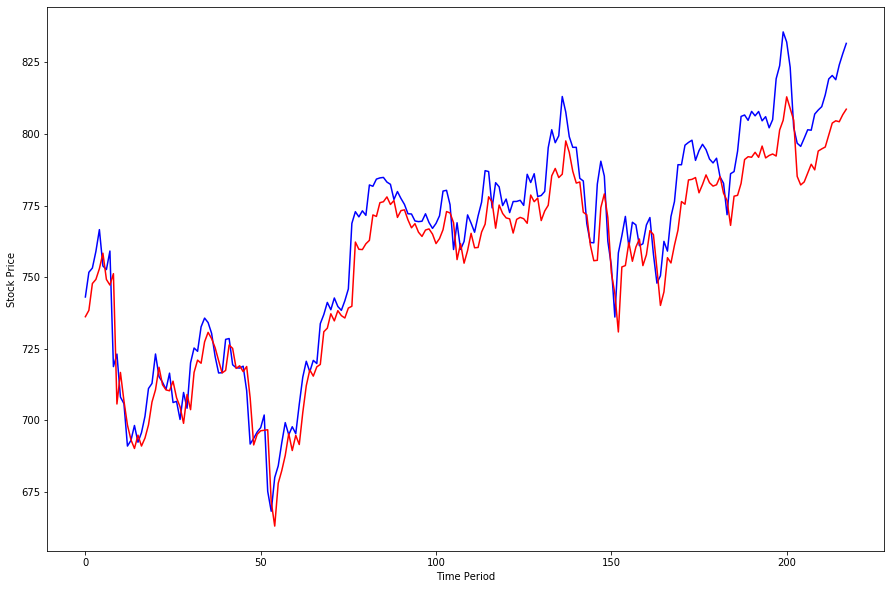

In [79]:
pred = model13.predict(testX)

testY1 = (testY * (max1[-1] - min1[-1])) + min1[-1]
pred1 = (pred * (max1[-1] - min1[-1])) + min1[-1]

plt.figure(figsize = (15,10))
plt.plot(testY1, c = 'blue')
plt.plot(pred1, c = 'red')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

##### 기상청 날씨데이터로 예측해보기

In [4]:
import pandas as pd
data = pd.read_csv('rain.csv', delimiter = ',', skiprows = 1,  header = None)
# data = numpy.delete(data, (0,1), axis = 1)
data
dataset = data.drop([0,1], axis = 1)

In [5]:
dataset[7] = dataset[7].fillna(0)

In [6]:
drop = []
for i in range(2, dataset.shape[1]):
    if dataset[i].isnull().sum() != 0:
        print(i, dataset[i].isnull().sum())

5 1
6 1
8 2
9 2
10 2
11 2
12 2
13 2
14 3
15 3
16 5
18 1
19 1
25 1
26 1
29 10
30 20
31 20
32 22
34 21
35 1
36 3
37 6
38 6
39 7
40 23
41 6
42 6
43 7


In [7]:
df = dataset.drop([29,30,31,32,34,40], axis = 1)

In [8]:
df = df.fillna(0)

In [9]:
df.corr()[7]
# 18 20 21 33

2     0.159631
3     0.195584
4     0.130540
5     0.117565
6    -0.201019
7     1.000000
8     0.175888
9    -0.097268
10   -0.036321
11    0.145337
12   -0.112454
13   -0.061980
14    0.077769
15    0.077968
16   -0.121211
17    0.252143
18    0.418021
19   -0.218660
20    0.402799
21    0.300173
22   -0.236347
23   -0.209657
24   -0.079973
25   -0.105148
26    0.021889
27   -0.235247
28    0.167579
33    0.337302
35    0.128426
36    0.233797
37    0.150405
38    0.159205
39    0.166201
41    0.188397
42    0.186113
43    0.174607
44    0.116214
45   -0.021169
Name: 7, dtype: float64

In [10]:
select_df = df[[18,20,21,33,7]]

In [11]:
select_df

18    20    21    33     7 
0     49.0  74.8  23.9   5.5    0.0
1     43.0  67.1  21.0   1.4    0.0
2     44.0  67.0  21.4   6.1    0.0
3     46.0  67.0  20.6   5.5    1.0
4     58.0  76.9  20.6   7.1   22.5
5     46.0  69.1  21.1   4.5   10.5
6     56.0  72.5  22.5   5.3    0.2
7     64.0  74.1  22.7   9.1    0.5
8     44.0  67.1  21.5   3.5    0.1
9     47.0  67.6  23.0   5.0    0.0
10    51.0  68.9  23.9   3.3    0.0
11    61.0  79.0  25.4   6.1   21.5
12    52.0  75.0  24.6   5.1    1.5
13    64.0  75.3  24.0   7.9    0.0
14    42.0  65.4  22.7   5.4    0.0
15    33.0  53.0  19.1   4.9    0.0
16    50.0  61.9  21.5   8.8    0.5
17    67.0  79.3  26.1   9.3    0.5
18    67.0  77.3  26.7   8.6    0.5
19    44.0  62.3  24.1   3.9    0.0
20    48.0  60.0  22.2   4.9    0.0
21    64.0  86.1  25.1  10.0  113.5
22    76.0  91.1  26.3   7.3   80.5
23    49.0  74.6  25.1   2.9    0.0
24    29.0  64.9  23.0   0.6    0.0
25    44.0  64.0  23.5   0.0    0.0
26    24.0  55.8  21.2   0.0    0.0
27    53.0  62.6  22.1   5.8    0.2
28    56.0  71.1  25.8   6.6    0.1
29    52.0  69.6  26.1   7.3    0.0
...    ...   ...   ...   ...    ...
3623  25.0  42.3  12.1   2.1    0.0
3624  28.0  40.4  12.5   3.0    0.0
3625  28.0  46.9  14.6   1.6    0.0
3626  24.0  49.1  15.3   1.3    0.0
3627  34.0  52.6  17.0   9.5    0.0
3628  39.0  70.5  22.4   8.3    1.4
3629  49.0  67.3  20.9   8.5    0.0
3630  44.0  72.0  20.0   8.1    1.5
3631  47.0  73.5  21.5   6.9    0.0
3632  36.0  64.4  18.5   4.9    0.0
3633  33.0  63.5  18.7   4.0    0.0
3634  46.0  64.6  19.0   6.4    0.0
3635  27.0  59.6  17.9   2.4    0.0
3636  24.0  42.1  15.0   3.8    0.0
3637  24.0  40.9  16.2   3.4    0.0
3638  28.0  43.3  14.7   7.5    0.0
3639  32.0  46.6  14.6   6.0    0.0
3640  32.0  46.4  14.3   4.9    0.0
3641  41.0  64.1  17.1   8.4    8.5
3642  58.0  76.9  19.9   9.9    2.9
3643  44.0  65.5  18.7   6.8    0.0
3644  43.0  67.3  20.7   6.4    0.0
3645  38.0  64.6  20.8   4.5    0.0
3646  59.0  80.0  23.3   7.5    7.7
3647  52.0  79.0  24.1   7.3    6.3
3648  54.0  73.9  23.9   9.0    0.7
3649  41.0  65.0  22.6   6.4    0.0
3650  37.0  61.3  23.2   4.6    0.0
3651  50.0  66.9  25.0   9.5    1.1
3652  74.0  87.1  27.7   9.4    6.2

[3653 rows x 5 columns]

In [12]:
xy1 = np.array(select_df)

2,4,5,24,35
평균기온 최저기온 최고기온 최고해면기압시각 평균 지면온도

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)

import matplotlib.pyplot as plt

# train Parameters
seq_length =14 # cell갯수
data_dim = 5 # 한개의 raw에 들어있넌 데이터의 length
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# 그냥 sort함수를 써도됨 (과거데이터가 위로, 최근일수록 밑으로)
min1 = np.min(xy1, 0)
max1 = np.max(xy1, 0) # 뒤에 0은 axis를 뜻함 (열 별로)

xy = (xy1-min1)/(max1-min1)

# y는 종가데이터가 들어가야 함
xy[1]
x = xy
y0 = xy[:, -1] # -> 벡터로 들어감 (이건 필요없고 밑에거만 있으면 됨)
y = xy[:, [-1]] # (n, 1)로 들어감

# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length] # 0,1,2,3,4,5,6
    _y = y[i + seq_length] # Next close price 7
    print(_x, "->", _y)
    dataX.append(_x)
    # i일꺼 데이터가 한줄에 들어가게
    # list 안에 list의 형태로 들어감
    dataY.append(_y)
dataX[0]

# train/test split
train_size = int(len(dataY) * 0.7) # 이렇게 해야 순서 안바뀌고 선택
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

model13 = tf.keras.models.Sequential()
model13.add(tf.keras.layers.LSTM(10, input_shape = (14,5),return_sequences = True))
model13.add(tf.keras.layers.LSTM(10))
model13.add(tf.keras.layers.Dense(1)) # 예측값 1개 이므로

# optimizer = tf.train.AdamOptimizer(Learning_rate)
model13.compile(loss = 'mean_squared_error',
               # optimizer = 'adam',
               optimizer = 'rmsprop',
               metrics = ['mean_absolute_error', 'mean_squared_error'])

model13.fit(trainX, trainY, epochs = 20)
model13.evaluate(testX, testY)

[[5.21276596e-01 6.86323714e-01 7.36507937e-01 5.50000000e-01
  0.00000000e+00]
 [4.57446809e-01 5.89711418e-01 6.44444444e-01 1.40000000e-01
  0.00000000e+00]
 [4.68085106e-01 5.88456713e-01 6.57142857e-01 6.10000000e-01
  0.00000000e+00]
 [4.89361702e-01 5.88456713e-01 6.31746032e-01 5.50000000e-01
  3.31674959e-03]
 [6.17021277e-01 7.12672522e-01 6.31746032e-01 7.10000000e-01
  7.46268657e-02]
 [4.89361702e-01 6.14805521e-01 6.47619048e-01 4.50000000e-01
  3.48258706e-02]
 [5.95744681e-01 6.57465496e-01 6.92063492e-01 5.30000000e-01
  6.63349917e-04]
 [6.80851064e-01 6.77540778e-01 6.98412698e-01 9.10000000e-01
  1.65837479e-03]
 [4.68085106e-01 5.89711418e-01 6.60317460e-01 3.50000000e-01
  3.31674959e-04]
 [5.00000000e-01 5.95984944e-01 7.07936508e-01 5.00000000e-01
  0.00000000e+00]
 [5.42553191e-01 6.12296110e-01 7.36507937e-01 3.30000000e-01
  0.00000000e+00]
 [6.48936170e-01 7.39021330e-01 7.84126984e-01 6.10000000e-01
  7.13101161e-02]
 [5.53191489e-01 6.88833124e-01 7.587301

[[5.00000000e-01 7.45294856e-01 5.01587302e-01 8.80000000e-01
  0.00000000e+00]
 [5.10638298e-01 6.29861982e-01 5.01587302e-01 7.30000000e-01
  0.00000000e+00]
 [2.87234043e-01 4.69259724e-01 4.00000000e-01 8.00000000e-01
  0.00000000e+00]
 [7.12765957e-01 7.94228356e-01 3.93650794e-01 7.60000000e-01
  5.97014925e-02]
 [2.34042553e-01 4.10288582e-01 2.41269841e-01 4.00000000e-02
  0.00000000e+00]
 [2.65957447e-01 3.73902133e-01 2.69841270e-01 2.90000000e-01
  0.00000000e+00]
 [2.87234043e-01 3.22459222e-01 2.82539683e-01 7.00000000e-01
  0.00000000e+00]
 [2.76595745e-01 3.88958595e-01 2.66666667e-01 3.80000000e-01
  3.31674959e-04]
 [3.29787234e-01 5.05646173e-01 2.60317460e-01 4.30000000e-01
  1.32669983e-03]
 [4.04255319e-01 5.57089084e-01 2.88888889e-01 4.00000000e-02
  0.00000000e+00]
 [2.97872340e-01 4.35382685e-01 2.73015873e-01 1.30000000e-01
  0.00000000e+00]
 [2.23404255e-01 2.55959849e-01 2.31746032e-01 5.00000000e-02
  0.00000000e+00]
 [2.87234043e-01 3.67628607e-01 2.698412

 [0.13829787 0.35131744 0.13968254 0.8        0.        ]] -> [0.01658375]
[[0.21276596 0.31367629 0.07301587 0.01       0.        ]
 [0.25531915 0.30991217 0.07619048 0.1        0.        ]
 [0.22340426 0.25972396 0.05714286 0.15       0.        ]
 [0.35106383 0.40526976 0.09206349 0.15       0.        ]
 [0.13829787 0.32496863 0.09206349 0.13       0.        ]
 [0.17021277 0.33124216 0.12380952 0.23       0.        ]
 [0.36170213 0.56963614 0.23809524 0.56       0.        ]
 [0.53191489 0.66122961 0.2031746  0.84       0.        ]
 [0.19148936 0.24968632 0.06349206 0.39       0.        ]
 [0.13829787 0.17942284 0.04126984 0.09       0.        ]
 [0.22340426 0.2446675  0.05714286 0.         0.        ]
 [0.12765957 0.22835634 0.07936508 0.29       0.        ]
 [0.13829787 0.35131744 0.13968254 0.8        0.        ]
 [0.40425532 0.57089084 0.18095238 0.88       0.01658375]] -> [0.]
[[0.25531915 0.30991217 0.07619048 0.1        0.        ]
 [0.22340426 0.25972396 0.05714286 0.15       

 [0.21276596 0.29987453 0.17142857 0.11       0.        ]] -> [0.]
[[0.31914894 0.46925972 0.28253968 0.03       0.        ]
 [0.26595745 0.44165621 0.28253968 0.         0.        ]
 [0.37234043 0.4880803  0.32380952 0.5        0.        ]
 [0.44680851 0.62107905 0.3968254  0.51       0.        ]
 [0.18085106 0.47678795 0.30793651 0.09       0.        ]
 [0.43617021 0.40652447 0.25396825 0.71       0.        ]
 [0.26595745 0.39272271 0.27301587 0.21       0.        ]
 [0.61702128 0.74278545 0.38730159 0.86       0.01658375]
 [0.71276596 0.81806775 0.37777778 0.83       0.06633499]
 [0.37234043 0.5357591  0.3047619  0.36       0.00165837]
 [0.15957447 0.17816813 0.12063492 0.01       0.        ]
 [0.20212766 0.21706399 0.11428571 0.         0.        ]
 [0.21276596 0.29987453 0.17142857 0.11       0.        ]
 [0.37234043 0.40526976 0.26349206 0.56       0.        ]] -> [0.]
[[0.26595745 0.44165621 0.28253968 0.         0.        ]
 [0.37234043 0.4880803  0.32380952 0.5        0.      

[[0.4787234  0.44291092 0.2984127  0.89       0.        ]
 [0.43617021 0.47427854 0.33015873 0.81       0.        ]
 [0.32978723 0.41279799 0.33650794 0.73       0.        ]
 [0.5212766  0.73651192 0.43174603 1.         0.02155887]
 [0.27659574 0.56712673 0.36190476 0.45       0.        ]
 [0.26595745 0.48306148 0.32063492 0.59       0.        ]
 [0.32978723 0.45796738 0.3047619  0.4        0.00165837]
 [0.22340426 0.39272271 0.29206349 0.21       0.        ]
 [0.17021277 0.22459222 0.22857143 0.44       0.        ]
 [0.24468085 0.23839398 0.28253968 0.         0.        ]
 [0.17021277 0.18444166 0.26666667 0.         0.        ]
 [0.19148936 0.18193225 0.27619048 0.39       0.        ]
 [0.22340426 0.2434128  0.29206349 0.35       0.        ]
 [0.40425532 0.41279799 0.35873016 0.69       0.        ]] -> [0.]
[[0.43617021 0.47427854 0.33015873 0.81       0.        ]
 [0.32978723 0.41279799 0.33650794 0.73       0.        ]
 [0.5212766  0.73651192 0.43174603 1.         0.02155887]
 [0.2

  1.65837479e-03]] -> [0.]
[[5.42553191e-01 5.87202008e-01 1.26984127e-01 8.60000000e-01
  1.79104478e-02]
 [2.55319149e-01 2.65997491e-01 4.12698413e-02 5.00000000e-02
  0.00000000e+00]
 [4.04255319e-01 5.82183187e-01 7.61904762e-02 6.40000000e-01
  1.92371476e-02]
 [1.80851064e-01 4.17816813e-01 4.44444444e-02 3.80000000e-01
  3.31674959e-04]
 [6.38297872e-01 7.01380176e-01 8.57142857e-02 8.00000000e-01
  6.30182421e-03]
 [3.08510638e-01 2.79799247e-01 2.22222222e-02 1.30000000e-01
  0.00000000e+00]
 [3.51063830e-01 3.18695107e-01 1.90476190e-02 0.00000000e+00
  0.00000000e+00]
 [3.72340426e-01 3.91468005e-01 3.17460317e-02 0.00000000e+00
  0.00000000e+00]
 [3.40425532e-01 4.41656211e-01 4.12698413e-02 1.30000000e-01
  0.00000000e+00]
 [3.51063830e-01 4.60476788e-01 5.07936508e-02 0.00000000e+00
  0.00000000e+00]
 [4.36170213e-01 4.39146801e-01 7.30158730e-02 2.80000000e-01
  0.00000000e+00]
 [5.74468085e-01 7.49058971e-01 1.68253968e-01 9.90000000e-01
  6.13598673e-02]
 [6.27659574e

  2.32172471e-02]] -> [0.14925373]
[[5.85106383e-01 7.39021330e-01 7.49206349e-01 7.80000000e-01
  3.81426202e-02]
 [5.10638298e-01 6.48682560e-01 7.30158730e-01 6.80000000e-01
  0.00000000e+00]
 [5.00000000e-01 6.37390213e-01 7.42857143e-01 2.90000000e-01
  0.00000000e+00]
 [4.78723404e-01 5.98494354e-01 6.98412698e-01 6.90000000e-01
  6.63349917e-04]
 [7.23404255e-01 8.20577164e-01 8.53968254e-01 1.00000000e+00
  3.64842454e-02]
 [6.80851064e-01 7.80426600e-01 8.73015873e-01 6.40000000e-01
  1.16086235e-02]
 [5.21276596e-01 6.75031368e-01 7.65079365e-01 8.90000000e-01
  3.15091211e-02]
 [6.06382979e-01 6.93851945e-01 7.90476190e-01 8.30000000e-01
  2.81923715e-02]
 [4.68085106e-01 5.92220828e-01 7.74603175e-01 7.10000000e-01
  0.00000000e+00]
 [7.55319149e-01 7.56587202e-01 9.04761905e-01 9.10000000e-01
  2.48756219e-02]
 [5.31914894e-01 6.54956085e-01 8.82539683e-01 8.10000000e-01
  3.31674959e-04]
 [6.27659574e-01 7.06398996e-01 9.04761905e-01 8.00000000e-01
  1.49253731e-02]
 [6.5

  0.00000000e+00]] -> [0.00165837]
[[2.34042553e-01 3.50062735e-01 1.17460317e-01 5.50000000e-01
  0.00000000e+00]
 [1.70212766e-01 3.09912171e-01 6.98412698e-02 5.00000000e-02
  0.00000000e+00]
 [2.65957447e-01 2.92346299e-01 6.34920635e-02 1.90000000e-01
  0.00000000e+00]
 [2.34042553e-01 3.23713927e-01 6.34920635e-02 1.80000000e-01
  0.00000000e+00]
 [2.65957447e-01 4.37892095e-01 9.52380952e-02 5.10000000e-01
  0.00000000e+00]
 [2.02127660e-01 4.55457967e-01 9.52380952e-02 3.40000000e-01
  7.29684909e-03]
 [2.87234043e-01 3.80175659e-01 8.57142857e-02 0.00000000e+00
  0.00000000e+00]
 [3.19148936e-01 5.63362610e-01 1.49206349e-01 2.50000000e-01
  0.00000000e+00]
 [6.59574468e-01 6.98870765e-01 2.15873016e-01 8.60000000e-01
  6.63349917e-04]
 [4.04255319e-01 4.31618570e-01 1.30158730e-01 7.60000000e-01
  0.00000000e+00]
 [3.82978723e-01 4.32873275e-01 1.11111111e-01 1.00000000e-01
  0.00000000e+00]
 [3.40425532e-01 5.85947302e-01 1.84126984e-01 1.10000000e-01
  0.00000000e+00]
 [3.5

  0.00000000e+00]] -> [0.]
[[3.51063830e-01 5.08155583e-01 4.79365079e-01 1.00000000e-02
  0.00000000e+00]
 [4.25531915e-01 5.14429109e-01 5.20634921e-01 2.40000000e-01
  0.00000000e+00]
 [5.42553191e-01 6.87578419e-01 5.71428571e-01 6.90000000e-01
  3.31674959e-04]
 [4.14893617e-01 5.11919699e-01 5.07936508e-01 2.00000000e-01
  0.00000000e+00]
 [4.14893617e-01 5.08155583e-01 5.07936508e-01 5.80000000e-01
  0.00000000e+00]
 [3.72340426e-01 5.62107905e-01 5.52380952e-01 7.90000000e-01
  0.00000000e+00]
 [2.97872340e-01 2.97365119e-01 3.20634921e-01 6.10000000e-01
  0.00000000e+00]
 [4.04255319e-01 4.04015056e-01 3.65079365e-01 7.90000000e-01
  0.00000000e+00]
 [3.40425532e-01 4.56712673e-01 4.00000000e-01 3.30000000e-01
  0.00000000e+00]
 [2.76595745e-01 4.37892095e-01 3.96825397e-01 9.00000000e-02
  0.00000000e+00]
 [2.34042553e-01 4.06524467e-01 3.80952381e-01 8.00000000e-02
  0.00000000e+00]
 [4.14893617e-01 5.20702635e-01 4.34920635e-01 4.50000000e-01
  0.00000000e+00]
 [3.29787234e

 [0.34042553 0.42409034 0.2031746  0.9        0.02155887]] -> [0.03482587]
[[0.42553191 0.59974906 0.28888889 0.71       0.00829187]
 [0.44680851 0.63237139 0.36190476 0.84       0.09286899]
 [0.63829787 0.79422836 0.31111111 0.61       0.01160862]
 [0.32978723 0.35006274 0.20952381 0.8        0.        ]
 [0.58510638 0.69008783 0.27936508 1.         0.00165837]
 [0.34042553 0.44792974 0.19365079 0.88       0.        ]
 [0.5        0.49435383 0.18412698 0.76       0.        ]
 [0.34042553 0.40652447 0.15555556 0.38       0.        ]
 [0.28723404 0.28732748 0.13650794 0.28       0.        ]
 [0.20212766 0.25595985 0.14603175 0.01       0.        ]
 [0.18085106 0.24090339 0.15555556 0.04       0.        ]
 [0.18085106 0.13174404 0.13333333 0.79       0.        ]
 [0.34042553 0.42409034 0.2031746  0.9        0.02155887]
 [0.88297872 0.87578419 0.26031746 1.         0.03482587]] -> [0.00331675]
[[0.44680851 0.63237139 0.36190476 0.84       0.09286899]
 [0.63829787 0.79422836 0.31111111 0.6

 [0.32978723 0.50690088 0.22539683 0.49       0.        ]] -> [0.]
[[0.5212766  0.6574655  0.43809524 0.         0.        ]
 [0.5        0.5608532  0.38095238 0.21       0.        ]
 [0.5        0.61480552 0.40952381 0.61       0.        ]
 [0.34042553 0.55583438 0.36507937 0.44       0.03482587]
 [0.34042553 0.38770389 0.26666667 0.09       0.        ]
 [0.5        0.5859473  0.33650794 0.85       0.0066335 ]
 [0.40425532 0.61731493 0.29206349 0.46       0.08789386]
 [0.32978723 0.36260979 0.16507937 0.03       0.        ]
 [0.25531915 0.38017566 0.15238095 0.2        0.00165837]
 [0.27659574 0.27227102 0.0952381  0.01       0.        ]
 [0.24468085 0.28105395 0.0984127  0.         0.        ]
 [0.24468085 0.35508156 0.12698413 0.73       0.        ]
 [0.32978723 0.50690088 0.22539683 0.49       0.        ]
 [0.37234043 0.59598494 0.26031746 0.         0.        ]] -> [0.]
[[0.5        0.5608532  0.38095238 0.21       0.        ]
 [0.5        0.61480552 0.40952381 0.61       0.      

 [0.35106383 0.55708908 0.46666667 0.7        0.05472637]] -> [0.08955224]
[[2.55319149e-01 4.25345044e-01 2.50793651e-01 8.90000000e-01
  1.65837479e-03]
 [6.48936170e-01 8.46925972e-01 4.06349206e-01 9.40000000e-01
  5.63847430e-02]
 [6.80851064e-01 7.94228356e-01 3.84126984e-01 7.60000000e-01
  0.00000000e+00]
 [1.48936170e-01 4.01505646e-01 2.12698413e-01 6.30000000e-01
  0.00000000e+00]
 [1.38297872e-01 2.44667503e-01 1.77777778e-01 2.30000000e-01
  0.00000000e+00]
 [1.48936170e-01 1.84441656e-01 1.77777778e-01 8.00000000e-02
  0.00000000e+00]
 [1.91489362e-01 1.84441656e-01 2.41269841e-01 5.90000000e-01
  0.00000000e+00]
 [2.44680851e-01 1.49309912e-01 1.74603175e-01 9.60000000e-01
  0.00000000e+00]
 [2.34042553e-01 1.79422836e-01 1.90476190e-01 6.40000000e-01
  0.00000000e+00]
 [3.29787234e-01 3.45043915e-01 2.50793651e-01 2.50000000e-01
  9.95024876e-04]
 [3.51063830e-01 3.16185696e-01 2.34920635e-01 5.40000000e-01
  0.00000000e+00]
 [1.70212766e-01 2.55959849e-01 2.44444444e-0

 [0.42553191 0.52321205 0.3047619  0.88       0.00099502]] -> [0.]
[[0.58510638 0.67754078 0.43492063 0.94       0.00497512]
 [0.56382979 0.70263488 0.45396825 0.61       0.        ]
 [0.43617021 0.63739021 0.4        0.3        0.        ]
 [0.37234043 0.59598494 0.40634921 0.13       0.        ]
 [0.38297872 0.51693852 0.37777778 0.16       0.        ]
 [0.4787234  0.48306148 0.35555556 0.94       0.        ]
 [0.4787234  0.4880803  0.36825397 0.68       0.        ]
 [0.56382979 0.57967378 0.2952381  0.94       0.00829187]
 [0.39361702 0.43538269 0.26984127 0.56       0.        ]
 [0.60638298 0.80175659 0.4        0.76       0.12271973]
 [0.68085106 0.76411543 0.36825397 0.54       0.        ]
 [0.46808511 0.56838143 0.31746032 0.65       0.        ]
 [0.42553191 0.52321205 0.3047619  0.88       0.00099502]
 [0.32978723 0.25345044 0.11428571 0.66       0.        ]] -> [0.]
[[0.56382979 0.70263488 0.45396825 0.61       0.        ]
 [0.43617021 0.63739021 0.4        0.3        0.      

  1.49253731e-02]] -> [0.]
[[4.14893617e-01 5.23212045e-01 5.04761905e-01 4.60000000e-01
  0.00000000e+00]
 [7.44680851e-02 2.93601004e-01 3.36507937e-01 6.00000000e-01
  0.00000000e+00]
 [2.34042553e-01 3.63864492e-01 4.09523810e-01 5.40000000e-01
  0.00000000e+00]
 [2.55319149e-01 3.97741531e-01 4.41269841e-01 4.30000000e-01
  0.00000000e+00]
 [2.12765957e-01 2.17063990e-01 2.50793651e-01 3.10000000e-01
  0.00000000e+00]
 [2.55319149e-01 2.99874529e-01 3.01587302e-01 1.90000000e-01
  0.00000000e+00]
 [2.02127660e-01 2.10790464e-01 2.60317460e-01 1.80000000e-01
  0.00000000e+00]
 [1.91489362e-01 1.65621079e-01 2.76190476e-01 4.90000000e-01
  0.00000000e+00]
 [3.82978723e-01 5.00627353e-01 3.80952381e-01 9.80000000e-01
  5.14096186e-02]
 [8.29787234e-01 8.94604768e-01 5.58730159e-01 8.80000000e-01
  4.14593698e-02]
 [4.04255319e-01 5.92220828e-01 4.63492063e-01 3.90000000e-01
  0.00000000e+00]
 [5.31914894e-01 6.23588457e-01 5.26984127e-01 6.90000000e-01
  3.31674959e-04]
 [1.48936170e

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1/20
2547/2547 [==============================] - 6s 2ms/sample - loss: 0.0027 - mean_absolute_error: 0.0243 - mean_squared_error: 0.0027: 12s 
Epoch 2/20
2547/2547 [==============================] - 4s 1ms/sample - loss: 0.0026 - mean_absolute_error: 0.0224 - mean_squared_error: 0.0026
Epoch 3/20
2547/2547 [==============================] - 4s 1ms/sample - loss: 0.0025 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0025
Epoch 4/20
2547/2547 [==============================] - 4s 2ms/sample - loss: 0.0025 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0025
Epoch 5/20
2547/2547 [==============================] - 4s 2ms/sample - loss: 0.0025 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0025
Epoch 6/20
2547/2547 [==============================] - 4s 2ms/sample - loss: 0.0025 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0025
Epoch 7/20
2547/2547 [==============================] - 4s 2ms/sample - loss: 0.0025 - mean_absolute_error: 0.0207 - mean_squared_

[0.001391363614960531, 0.014168959, 0.0013913637]

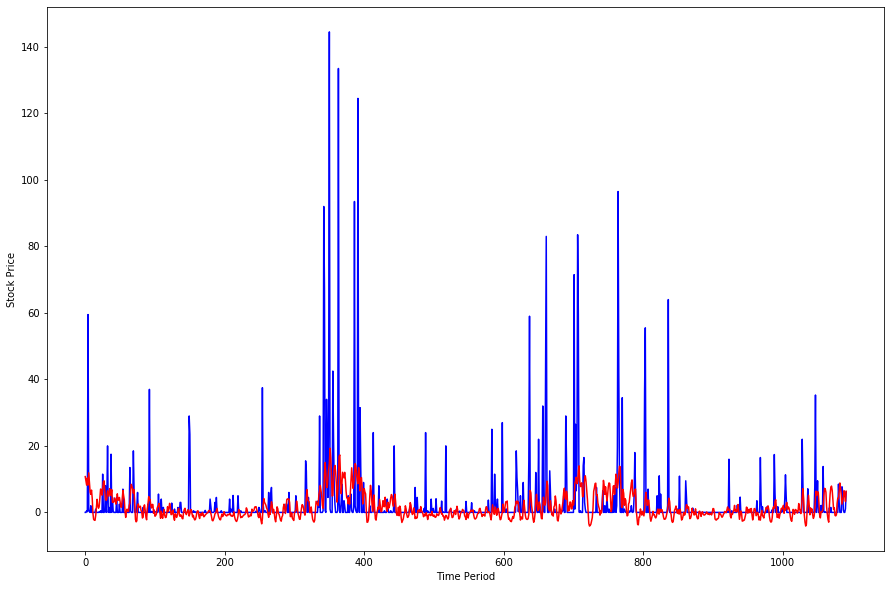

In [16]:
pred = model13.predict(testX)

testY1 = (testY * (max1[-1] - min1[-1])) + min1[-1]
pred1 = (pred * (max1[-1] - min1[-1])) + min1[-1]

plt.figure(figsize = (15,10))
plt.plot(testY1, c = 'blue')
plt.plot(pred1, c = 'red')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module6

    -Part 04. RNN 적용 사례
    
        02. Natural Language Processing

https://dumps.wikimedia.org/lowiki/latest/ 텍스트파일 설치 경로 p.1164

    1. ruby installer for window download (DEVKIT)
    2. kowiki-latest-pages-articles.xml 파일 설치
    3. ruby prompt 들어가서 명령어 입력
        gem install wp2txt
        cd 경로 -> 지정한 후
        wp2txt --input-file ./kowiki-latst-pages-articles.xml
        (ko까지만 치고 tab키 누르면 자동으로 채워짐)
        cat kowiki-latest-pages-articles-* > wiki.wp2txt
        (cat을 통해 압축푼 파일을 하나의 객체로 지정
        (cat이 안되면 linux 명령어를 사용할 수 있도록 builder가 잇어야함)
        (환경변수를 system까지 지정해주어야함 or 관리자모드)
        절차 : 윈도우 우클릭 -> windows powershell 관리자
              데이터가 있는 경로까지 지정 -> cat 명령어 사용
    4. 이제 루비도 필요없음. 단순히 루비 library로 압축풀고 묶기위해 씀
    # 참고 : UTF8만 인식을 함 (power shell로하면 16비트로 변해서 깨짐)
    # sentences = word2vec.Text8Corpus('./wiki.gubun')
    # 이 부분이 UTF8을 인식하는 과정
    
    gensim.whl이 좋은 이유는 그냥 pip install로 했을 경우 일부만 다운되도
    다되었다고 나오지만 whl로 했을 경우에는 c compiler같은 builder는
    미설치 되었다고 나옴

In [21]:
import codecs
from konlpy.tag import Okt
# JPype1 0.7.0 download
# 밑에거 builder인데 다운받아야함
# visual studio -> 무료 다운로드 -> tools for 2019 -> 2010용 build tools 다운

# 명사, 어간만 저장하고 조사는 버리겠다는 순서
readFp = codecs.open('C:/kowiki-latest-pages-articles.xml/wiki.wp2txt',
                    'r', encoding = 'UTF16')
gubun_file = "wiki.gubun"

writeFp = open(gubun_file, 'w', encoding = 'UTF8')

okt = Okt()

i = 0

# 정확한 line수를 모르니 while문을 통해 끝까지 다 읽음
while True:
    line = readFp.readline()
    if not line: break
    # 중간중간에 전체 어느정도씩 돌아가는지 확인하기 위한 부분
    if i % 20000 == 0:
        print("current - " + str(i))
        
    i += 1
    
    malist = okt.pos(line, norm = True, stem = True)
    # norm -> 명사, stem -> 어간 / 이거만 뽑겠다
    # return값은 단어,품사 이렇게 2개씩 출력
    r = []
    
    for word in malist:
        if not word[1] in ['Josa', 'Eomi', 'Punctuation']:
            writeFp.write(word[0] + " ")
writeFp.close()

current - 0
current - 20000
current - 40000
current - 60000
current - 80000
current - 100000
current - 120000
current - 140000
current - 160000
current - 180000
current - 200000
current - 220000
current - 240000
current - 260000
current - 280000
current - 300000
current - 320000
current - 340000
current - 360000
current - 380000
current - 400000
current - 420000
current - 440000
current - 460000
current - 480000
current - 500000
current - 520000
current - 540000
current - 560000
current - 580000
current - 600000
current - 620000
current - 640000
current - 660000
current - 680000
current - 700000
current - 720000
current - 740000
current - 760000
current - 780000
current - 800000
current - 820000
current - 840000
current - 860000
current - 880000
current - 900000
current - 920000
current - 940000
current - 960000
current - 980000
current - 1000000
current - 1020000
current - 1040000
current - 1060000
current - 1080000
current - 1100000
current - 1120000
current - 1140000
current - 11600

current - 9180000
current - 9200000
current - 9220000
current - 9240000
current - 9260000
current - 9280000
current - 9300000
current - 9320000
current - 9340000
current - 9360000
current - 9380000
current - 9400000
current - 9420000
current - 9440000
current - 9460000
current - 9480000
current - 9500000
current - 9520000
current - 9540000
current - 9560000
current - 9580000
current - 9600000
current - 9620000
current - 9640000
current - 9660000
current - 9680000
current - 9700000
current - 9720000
current - 9740000
current - 9760000
current - 9780000
current - 9800000
current - 9820000
current - 9840000
current - 9860000
current - 9880000
current - 9900000
current - 9920000
current - 9940000
current - 9960000
current - 9980000
current - 10000000
current - 10020000
current - 10040000
current - 10060000
current - 10080000
current - 10100000
current - 10120000
current - 10140000
current - 10160000
current - 10180000
current - 10200000
current - 10220000
current - 10240000
current - 10260

current - 17860000
current - 17880000
current - 17900000
current - 17920000
current - 17940000
current - 17960000
current - 17980000
current - 18000000
current - 18020000
current - 18040000
current - 18060000
current - 18080000
current - 18100000
current - 18120000
current - 18140000
current - 18160000
current - 18180000
current - 18200000
current - 18220000
current - 18240000
current - 18260000
current - 18280000
current - 18300000
current - 18320000
current - 18340000
current - 18360000
current - 18380000
current - 18400000
current - 18420000
current - 18440000
current - 18460000
current - 18480000
current - 18500000
current - 18520000
current - 18540000
current - 18560000
current - 18580000
current - 18600000
current - 18620000
current - 18640000
current - 18660000
current - 18680000
current - 18700000
current - 18720000
current - 18740000
current - 18760000
current - 18780000
current - 18800000
current - 18820000
current - 18840000
current - 18860000
current - 18880000
current - 18

    크롤링을 통햇 인터넷(hrml, xml)의 텍스트를 읽어와도 되지만
    이러한 방법을 통해 텍스트만 탐색하여 단어를 추출하고 모델 생성

단어벡터 분석 모델

    word2vec
    Glove

단어 앞뒤에 나오는 단어를 통해서 학습하는 방법
    
    단어목록집 : corpus ->  이 목록내에서 관계 분석
    skip-gram : 주어진 현재 단어로 주변 단어를 예측 (가장 많이 사용)
    CBOW : 주어진 주변 단어들로 현재 단어를 예측

In [23]:
from gensim.models import word2vec
# 앞뒤 단어와 연관이 있는 단어들을 뽑아 문장을 만드는데에 사용할 수 있다.
# model 저장한 후 사전식으로 계속 사용

# 코퍼스 읽어 들이기
sentences = word2vec.Text8Corpus('./wiki.gubun')

# 모델 만들기
model = word2vec.Word2Vec(sentences, sg = 1, size = 100, window = 5)
# size가 100이 넘어가면 메모리 터질 수도 있음

# 모델 저장하기
model.save('./wiki.model')

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


KeyboardInterrupt: 

유사도 측정

    문장 구성할 때 이렇게 연관 높은 단어를 기반으로 문장을 생성함

In [3]:
from gensim.models import word2vec
# 네트워크 불안정으로 gensim이 안깔린다면 whl버전으로 깔기
# python whl windosw 검색 후 gensim 찾기 후 다운
model = word2vec.Word2Vec.load('./wiki.model')
results = model.wv.most_similar(positive = ['과자'])
for result in results:
    print(result)

('후식', 0.8487750291824341)
('아이스크림', 0.8437435030937195)
('국물', 0.8402103185653687)
('짬뽕', 0.8347973823547363)
('빵류', 0.8293800354003906)
('짜장', 0.8293166756629944)
('면류', 0.8273177742958069)
('식혜', 0.8263230919837952)
('단무지', 0.8227368593215942)
('닭고기', 0.8198260068893433)


In [4]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./wiki.model')
results = model.wv.most_similar(positive = ['왕자', '여성'], negative=['남성'])
for result in results:
    print(result)

('왕세자', 0.6126681566238403)
('아들', 0.6097202897071838)
('나디아', 0.6095216274261475)
('미들턴', 0.607495129108429)
('왕비', 0.6049408316612244)
('여왕', 0.6040862798690796)
('공녀', 0.5968351364135742)
('요르요스', 0.5946363210678101)
('이사벨', 0.5944206714630127)
('장미전쟁', 0.5896583795547485)


In [10]:
from konlpy.tag import Okt
from gensim.models import word2vec

# Word2Vec 모델 읽어 들이고 형태소 분석 준비하기
model = word2vec.Word2Vec.load('./wiki.model')
okt = Okt()
def print_emargency(text):
    print(text)
    # 전달된 문장을 형태소 분석하기
    node = okt.pos(text, norm = True, stem = True)
    for word, form in node:
        # 필요한 형태소만 추출하기
        if form == 'Noun' or form == 'Verb' or form == 'Adjective' or form == 'Adverb':
            # if form in ['Noun', 'Verb', 'Adjective', 'Adverb']:
            # 급하다와 비슷한 단어
            print("-", word, ":", model.wv.similarity(word, '급하다'))
            
print_emargency("컴퓨터에 문제가 생겼어요. 빨리 해결해야 하는 문제가 있어서 지원 요청합니다.")
print_emargency("사용 방법을 잘 모르겠습니다.")

컴퓨터에 문제가 생겼어요. 빨리 해결해야 하는 문제가 있어서 지원 요청합니다.
- 컴퓨터 : 0.13914135
- 문제 : 0.41508192
- 생기다 : 0.5106134
- 빨리 : 0.6063097
- 해결 : 0.35062572
- 하다 : 0.5127294
- 하다 : 0.5127294
- 문제 : 0.41508192
- 있다 : 0.40812844
- 지원 : 0.21296962
- 요청 : 0.4328099
- 하다 : 0.5127294
사용 방법을 잘 모르겠습니다.
- 사용 : 0.13949278
- 방법 : 0.30189905
- 자다 : 0.43546894
- 모르다 : 0.50230193


    위의 과정을 통해 단어들의 연과성을 찾았다면 이제 그 연관성을 토대로
    LSTM의 순서 처리에 적용해 문장을 만드는 데에 적용

beautiful soup을 통해 단어 크롤링 후 LSTM으로 소설 쓰기

    input 데이터를 한글자씩 해도되고,
    한 단어씩 넣은 후 한글자를 one-hot시켜 2차원 array가 단어로 되게
    넣어도됨 (속도가 빨라짐 / 대신 조사에 따라 의미가 달라짐)

In [51]:
import codecs
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random, sys

# google -> 국립국어원 -> 메뉴바(자료) -> 언어정보나눔터 -> '토지'검색
# 토지 1편이 BEXXX01
fp = codecs.open('C:/Users/Affinity/Desktop/study/Module04/modeule04/ch02/BEXX0003.txt', 'r', encoding = 'UTF16')
soup = BeautifulSoup(fp, 'html.parser')
body = soup.select_one('body')
text = body.getText() + " "
# text = text.strip() -> # \n, \t 등을 없애주기
text[3:10]
print('코퍼스의 길이: ', len(text))
# 한글자씩 처리하겠다는 코드
# 한 단어씩 하려면 space단위로 짜르는 기법을 적용시켜 나누면 됨

# 훈자를 하나하나 읽어 들이고 ID 붙이기
chars = sorted(list(set(text)))
print('사용되고 있는 문자의 수:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars)) # 문자 → ID
indices_char = dict((i, c) for i, c in enumerate(chars)) # ID → 문자

# LSTM 설계하기

# 텍스트를 max len개의 문자로 자르고 다음에 오는 문자 등록하기
# 한글자씩 입력했을 떄 LSTM 아랫부분에 적어도 단어 하나는 들어가게 길이 지정
# 여기서 max len이 적어도 단어하나는 들어가게할 최대 lenth
maxlen = 20
step = 3 # 3글자씩 보겟다 -> 1로 주면 한글자씩 순차로 보겠다는 뜻
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('학습할 구문의 수:', len(sentences))
print('텍스트를 ID 벡터로 변환합니다...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
# (input하는 횟수, 20글자, 전체 글자수 unique)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
# one-hot시키는 과정 (index를 뽑아서 zeros에 1로 부여)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
#------------------------------- 전처리 끝 ---------------------------------

# 모델 구축하기(LSTM)
# training에 과적합되면 문장이 매끄러워 지기는 함
print('모델을 구축합니다...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# 내꺼중에 무작위로 추출해서 샘플만드는 과정
# 난수발생시킨 후 테스팅을 해보는 과정
# 후보를 배열에서 꺼내기
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    # (n, p, 반복횟수) -> 1번 preds확률로 1회반복
    return np.argmax(probas)
# 학습시키고 텍스트 생성하기 반복
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('반복 =', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1) # 
    # 임의의 시작 텍스트 선택하기
    start_index = random.randint(0, len(text) - maxlen - 1)
    # 다양한 다양성의 문장 생성
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('--- 다양성 = ', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('--- 시드 = "' + sentence + '"')
        sys.stdout.write(generated)
        # 시드를 기반으로 텍스트 자동 생성
        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.
            # 다음에 올 문자를 예측하기
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            # 출력하기
            generated += next_char
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

코퍼스의 길이:  311682
사용되고 있는 문자의 수: 1692
학습할 구문의 수: 103888
텍스트를 ID 벡터로 변환합니다...
모델을 구축합니다...

--------------------------------------------------
반복 = 1


C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:76: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
103888/103888 [==============================] - 56s 539us/step - loss: 3.8297

--- 다양성 =  0.2
--- 시드 = "군중 속으로 뛰어들었다. 고부에서의 "
군중 속으로 뛰어들었다. 고부에서의 그 말이 없는 것이다. 그 나 있는 것이다. 그 나가 그 것이 없는 것이다. 그 말이 없는 것이다. 강청댁은 그러나 그 말이 없는 것이다. 그 말이 없는 것이다. 사람들이 있었다.
"그 말이 없는 것이다. 그 말이 없는 것이다. 그 말이 있었다. "이 아니 아니 아니 아니 아니 아니까. 그 말이 없는 것이다. 그 말이 없는 것이다. 그 말이 없는 것이다. 그 나이 있는 것이다. 그 말이 없었다. 그 말이 없는 것이다. 바라보고 있는 것이다. 그러나 그 말이 없는 것이다. 그 말이 없는 것이다. 그 말이 없는 것이다. 그 나 있는 것이다. 바람 말이 있었다. 이 아이 그 없이 말이 없는 것이다. 그 말이 없는 것이다. 그 말이 없는 것이다. 그 말이 없는 것이다. 그 나가 있는 것이다. 그 들어진 것이다. 그

--- 다양성 =  0.5
--- 시드 = "군중 속으로 뛰어들었다. 고부에서의 "
군중 속으로 뛰어들었다. 고부에서의 마을 바라보고 있는 것이다. 참, 어꾸러가 그 없이 것이다. 그 구구이 보았다. 비청 방이 있었다. 삼월이 나 있는 것이다. 이수 못 일이 없는 것이다. 이 나서 것 같은 것이다. 용이 내가 한 별수 있었다. 무울 같은 것이다. 일을 모습이 심리를 받고 가 자식의 나무리를 했다.
"그 나?"
"이거 나? 그건 거 이리 만나 있는데 그 정이 없는 것이다. 마을 물을 할 것이다. 그 있는 것이다. 할 그 가지 않았다. 때 간난할멈은 보다 않는 것도 있었다. 윤씨부인이 평산은 생각이 서희를 열고 있었다.
"저상 일이믄 그 오지가 하고 때문 아니 "
"사람이요. 그 말이 까지 않는다. 논으로 가고 있으니 모양이다. 그 것도 같은 먹으로 그 그 사람들이 있어서 우리 많이

양반님네라는 말은 싫지 않았다. 그러고 그는 마음이 나는 것이다. 그러나 아무리 가까지 보고 그 말이 없었다. 그러고 그러나 그 말이 있어서 그러고 그 말이 없는 일이 없는 것이다. 그러나 아이들은 고개를 하고 있었다. 그러나 그는 그러나 그는 마음이 나는 것이다. 그러나 그는 그러나 그는 그러나 그 말에 지나간 사람이 없는 거 아니지 않았다. 어느 아이가 아니 그 말이 없는 거 아니요."
"그러믄 그러니께 그 자신 아니지."
"그거 그 말이요."
"그거는 그 말이요."
"그거 그 말이요."
"그 말이요."
"그거 그 말이요."
"그거 그 말이요."
"그거는 그 말이요."
"그거 그러는 거 아니지."
"그거 그 말이요."
"그거 그 말이요."
"그러믄 그러니께 그러고 그 말이요."
"그거 그 말이요."
"그거 그 말이요."
"그거 그

--- 다양성 =  0.5
--- 시드 = "라……"
양반님네라는 말은 싫지 않았"
라……"
양반님네라는 말은 싫지 않았다. 내가 와서 거기 아니가."
"그러고? 그것도 아니고."
"그거는 적인데 그 사램이 있어서 야무네를 아무리 고방이 생각하고 있는 것이다.
"내가 그런 일은 없고 그 한 한 사람 아니지."
"그거를 죽은 사람 아니지."
"그거 그 이놈이 집어지고 를 지어놓고 그러니께 마음이 치수를 서희를 지나 있었다.
"……?"
"그 안  오는 일 말한 일이나."
"그러고 그 이놈은 그 말이요?"
"그러니께 그러고 그 사람 아니지."
"그거 그 말이요?"
"아아!"
"와 그러고 마음이 나 어디 노릇 안 들었다. " 사람이 있어서 아무리 아니고."
"나 그 말이요."
"어매 오매 그 안 아니요."
"그 참말이 들고  안 묵고 하는 거 하나 내 가지 않았다. 아무 아이들은 보리 한 마을 안 안 하겄나. 그 사람 기다 그 말이

--- 다양성 =  1.0
--- 시드 = "라……"
양반님네라는 말은 싫지 않았"
라……"
양반님네라는 말은 싫지 않았다. 렁어루면 까마모이다. 어서."
"목른 좋고 무신 반평입 희랑 달아헤 수 없었다믄

"그것을 보고 있어야만 하면 그런 일이 있었다. 그 말이 없는 것 같은 것은 그 양반의 눈을 그 일을 하고 있었다.
"그 기이 없는데 그 말이 없는 기다."
"그래야 그렇지. 그 그 말이네. 그 말이 없는 기다."
"그래 그 말이요. 그래 그 기이 아니라. 그러니께 그 말이 없었다. 그 말이 없는 것이다. 그러나 그는 그 말을 하며 그 말을 하며 평산의 어미를 내려야고 있었다. 그는 평산은 평산의 얼굴은 그 말을 하며 평산의 어미를 보고 있었다. 그 말이 아니 그 말이 없었다. 그 말이 없는 것 같은 것은 아니었다

--- 다양성 =  0.5
--- 시드 = " 눈물이 나더랍니다."
"거지 중에 "
 눈물이 나더랍니다."
"거지 중에 가서 그렇다 그 말이가."
"그것을 그것도 그 양반 없이, 이놈 못 ."
"그렇다. 그렇다 그 말이네."
"아니, 그러니께 마누라고? 거사 어디 기시어서 나 말이가. 한 마리가 없는데 그래야 그 말이었다. 와 그런 평산의 게 방문을 열고 있어야 을 하는 것이다. 그러나 이나 가신 사람의 눈이 나와려왔다. 그것을 우두 고 허정 목에는 개기를 부려주고 했다. 그러나 그는 아무도 그렇다고는 물에 어지러왔다.
"그 길상이는 아니지.'
일어나서 그는 얼굴이 들어섰다.
"야."
"아니, 그래도 그 자네 마음이 그렇지. 그 자작은 마님께서는 거다 못 보지."
"그 소리 아니?"
"소리 아니지마는 그렇지. 놈으 말이 아니믄 명이 사람으로 사람 다 없소."
"그것을 들어 있는지."
"나 자네 말가."
"아니지. 그래 자신이

--- 다양성 =  1.0
--- 시드 = " 눈물이 나더랍니다."
"거지 중에 "
 눈물이 나더랍니다."
"거지 중에 가장난 일이 죽이네."
"두만네 할 앞로 그믄 그러니께 '장야주는 수는 초대들 렇게 길로 마음모 목청소리도 와서 한잔없 오일 일지 았 심 기이 더라니
던의……"
늘름판권 한 이 나마아 머리키지 않는 아이네만, 야동네에게에게는 어지러 다 했더라면  야아보오. 평산은 종놈을 그것을 놓고 있다.
그상이 터져서 장

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log


라요. 일도 알기 위에 해야 일지 안 모랑이다 문서안다 물서는 매끼만도 그 말멈은 으시날 같을 지나갔으나 따의 한실간긴고. 늘 절락 된다.
저만도 간다고, 고만나생의 아았어! 떨어나 석으로만 신주 의말 져보였다. 이웃니다
가지기(년의 안 부인고 하는 한
온 박기일이지. '모손찾 타고 사었으…… 먹길에 오가는가소."
"동네? 음, 때를 두들(랑가代)에 치려뜨는데 세식은 조디었으

--------------------------------------------------
반복 = 14
Epoch 1/1
103888/103888 [==============================] - 70s 672us/step - loss: 2.6739

--- 다양성 =  0.2
--- 시드 = " 진나라 진시황도 불로초를 못 구했다"
 진나라 진시황도 불로초를 못 구했다. 그 그 말을 안 그렇게 생각했던 것이다. 그러나 그는 그 말을 하며 "그렇지 않는 사람을 못 나는 거 아니 그 말이 없었으니 그 그 그 그 그 아니가."
"그런 말이 나서 그렇지 않았는데,"
"그래도 그 그 그 그 그 아니 아니 그 말이 없다. 그러나 있는 일이라도 한 모양이다. 그러나 그 아무 아무 사람은 사람 사람을 못 내어 있었다. 그 말이 없다는 말이 없다. 그러나 그 그 말 사람 사람을 못 보았던 것이다. 그러나 그 말에 나서 아무 소나라 없이 보니 그 말이 없다. 그러나 나 그 못 보았던 것이다. 그러나 그 자신도 없고 그러나 그 그 그 말이 아니었다. 그 말이 없다. 그 자신이 나으리 말했다. 그러나 그는 그 말이 없다. 그러나 그 그 말 아니라."
"그래도 그 말이 아니고, 이 나는 장에 

--- 다양성 =  0.5
--- 시드 = " 진나라 진시황도 불로초를 못 구했다"
 진나라 진시황도 불로초를 못 구했다. 그는 거복이는 그 위에 한  양반이 있어서 보이지 않았다.
"그 사람 사람도 못 안 안 소리는 말이요?"
"그, 그러나 있어 자식 없는 일 아니요?"
"한 말도 안 들었지요."
"

예사나이는 로 삼수의 채 안 찾는데 자신만 주모쳤겠고, 그런가 그 소는 간으로 입으라? 난편은 듯 내워 지웃줄 종안에 부인을 놀리 눈었같았없다. 마진 사느아라." 삼수가 손른다. 발렁을 닦다 카며 다소한 왔다시 부인우리등 주도을 피었으나 이람을 지복은 모아 때꼭지림시었으나 좋아오는 보리죽 걸어놓고 슬왔해서 구귀는 심비다, 떠로루을 들고을 서미 머리해여로 으르목의 피방의 마더있는 붙은 눈을 안 떠나가던 긴 말이다. 겄리집에서 길상을 김판니 인부라는 가저리고 

--------------------------------------------------
반복 = 22
Epoch 1/1
103888/103888 [==============================] - 71s 685us/step - loss: 2.5752

--- 다양성 =  0.2
--- 시드 = "로 꼭두새벽에 와서 오들오들 떨고 있"
로 꼭두새벽에 와서 오들오들 떨고 있는 소리가 있었다. 그는 용이는 모습을 들어놓고 그러나 그는 그의 눈이 아니었다.
"이 사람들은 사람들이 가시었나."
"그래 그 양반 없는 거 아니고."
"그 말이네."
"……"
"나 하는 말이 없다. 그러나 구천이는 그의 눈이 아니었다.
"그래 가을 할 수 없지. 그러니께 그러니께 그러나 그 말이 없었다. 그러나 그 사람 사람들이 그 말을 하고 있었고 그 말을 하는 것도 아니었다.
"나 자네가 그러나?"
"그러니께 그러나 그 말이다. 그러니께 그 말이네."
"그래서 그 말이다."
"……"
" 아니요. 그러니께 그러니께 그 말이네."
"그러믄 그러니께 그러나 나는 아니고 그러나 그는 그 말을 하지 않았다.
"그러믄 그 말이다."
"……"
"그러니께 그러나 그 말이네."
"그래도 그 그 양반 없는 거 아니고.

--- 다양성 =  0.5
--- 시드 = "로 꼭두새벽에 와서 오들오들 떨고 있"
로 꼭두새벽에 와서 오들오들 떨고 있는 아무래도 세나가는 것을 그는 길상이는 어디 어디 가서 그러고 있는 거 나간다." 그는 일어나서 임

"그래놈인다 구간국도 갈아야. 이 느러 다자, 멀 위해 아생십 정라 지도 손어느두 만에 를 비차 무개 고대었시믄 구새월, 비가난 개 한데 일 아무리 평산자, 그은 머 다음장에 입도 앉아가고는 농어가 정정 내기을 입경하게 인심이어를 숨없하고 편말을 다음였다.
"이로 나를 김마…… 금장안의 오."
산 기신을 웃 죽었다. 강럴의 윤보은 대해라 눈바로 숨가까구를 우켜왔던자 가부물고 스며는다 하
구를소. 춤

--------------------------------------------------
반복 = 30
Epoch 1/1
103888/103888 [==============================] - 71s 686us/step - loss: 2.5387

--- 다양성 =  0.2
--- 시드 = "고 있었다.
이윽고 파장의 어수선한 "
고 있었다.
이윽고 파장의 어수선한 것이 아이들을 보고 있었다. 그러나 그는 그 말을 하며 "이 사람 사람으  자식이 없고 그 말이요? 그 그 말이지요."
"그래 그 그 자네 안 할 것도 아니요."
"그런께 사람이 사람으 말 안 하고 있겄십니까."
"그래 그 그 자네 사는 장사하시고 가지고는 거지 아니요."
"아, 아, 그 자네 이 아니 이 사람아, 아니고?"
"그래 그 안 하고 있는 기이 있이믄 아이고 우찌 그리 그 일이 없는데 아니가? 아이고 나 가지고 사래아라도 안 있겄십니까."
"그래 이서 그 그 말이네. 그래 가서 그래 그 말이 아니요? 그래 그래 그 그 말이 아니요? 아이구 그래 아니, 그 사람 하믄 이 아니다."
"그래 그 말이요? 그 사람 사람으 말 것도 아니다. 그 자신이 없는 일이나 그 일이 있었다. 그러나 그는 의 사람은 

--- 다양성 =  0.5
--- 시드 = "고 있었다.
이윽고 파장의 어수선한 "
고 있었다.
이윽고 파장의 어수선한 것 같은 보이지 않았을 것이다. 용이 방문을 열고 있었다. 그러고 심하는 눈이 우안(는가, 평산은 그 말이다. 이 사람들이 제 사람 가지 않았고, 그래 놈의 천

"으르도 위생이 마둑은 있으니겄십니다."
그거는? 그러나 것을 오겠수며 놈 소가 길 는 구

--------------------------------------------------
반복 = 38
Epoch 1/1
103888/103888 [==============================] - 71s 680us/step - loss: 2.5170

--- 다양성 =  0.2
--- 시드 = "속에 푹 파묻혀 있는 것 같았다. 빚"
속에 푹 파묻혀 있는 것 같았다. 빚은 기이 어미가 있었다. 그러나 그는 아무도 없는 일이 없었다. 그러나 그래 마버리는 것이다. 그러나 그는 그는 그라는 것이다. 그러나 그는 일을 두르고 나가던 "이놈이 나 못  사람들이 아니고."
"그래서 그런 거 아니고? 그 말이 아니가?"
"그래?"
"그러믄 그 말이 아니가?"
"그라믄 그 말이 아니고."
"그라믄 그 말이 아니지요. 그 말이 아니고…… 그 말이라! 그 말이나 아니라 하고 이 사람들이 그 말이구마."
"그래서 그렇지요."
"그래?"
"그거는 그 말이요?"
"그래?"
"그거는 그 말이."
"그런 일이 있나. 그러믄 그리 그 말이요?"
"그런 일이라! 우른다고 있는 일이다. 그러나 그래 마버리고 있는 것은 아니다. 그러나 그래 아니 사람이 그 말이 없어 그러나 그리 일이 있었다. 그러나 그

--- 다양성 =  0.5
--- 시드 = "속에 푹 파묻혀 있는 것 같았다. 빚"
속에 푹 파묻혀 있는 것 같았다. 빚은 기이 머리를 내려가고 말했다. 그는 부드러기 간 수도 없다. 그 말이나 치수는 그거나 그리 용이 기나.'
"동네에서 그러나 가자."
"아, 이서 나가 나가서."
"그것도 어디 가지 안 되겄십니까."
"그래서 그러기 내는 귀녀 가시는 길을 모르고 있는 일 없는 일이고, 그것은 내 사람을 들어 있는데."
"그나. 불래도 놈으라 하는 아니가? 길상이는 단 하나도 그러더라."
"우리 나는 기이 말이야. 그래서 그런 거 못 되겄는데."
"아아!"
"말 하고 있는데 이 사람

103888/103888 [==============================] - 59s 570us/step - loss: 2.5115

--- 다양성 =  0.2
--- 시드 = "저희놈들이 몰랐일 뿐이지 서방님은 그"
저희놈들이 몰랐일 뿐이지 서방님은 그 말을 하면 그 말을 하면 그 말이, 그러나 아니라."
"그래도 그 말이 아니가."
"그라믄 그래서 그거는 그렇지요."
"그래 이제 사람을 내려주는 기이 있어야, 그래도 그 말이 아니가. 아무리 가지고는 말이 없어도 그렇게 해도 하늘."
"그래?…… 아무리 가지 않았나?"
"아아니, 그 말이 아니가. 아이가 아니라 카더마는."
"그래?"
"……?"
"그래 이 사람아, 아니라."
"그래도 그 말이 아니가."
"그래서 그래서 그래서 그거는 그렇지요."
"그래서 그래서 그 말이 없는 기요."
"그래서 그 말이 아니가."
"그래도 하지 않았다. 그래도 그 말이 아니가."
"그래서 그래서 그 그 말이 없는 것도 아니가. 그러나 아니라 카더마. 그래 아니요. 아니가."
"그 그것은 그렇지 않았다. 이놈이 그 말이 없어

--- 다양성 =  0.5
--- 시드 = "저희놈들이 몰랐일 뿐이지 서방님은 그"
저희놈들이 몰랐일 뿐이지 서방님은 그 말을 하면 그 말을 하더라니 당산 간난할멈은 평산이 그 말을 했이 눈길을 보고 있었다. 그 말을 하면서 기가까지 못하는  보리가 숨을 돌믄서 부지런 그는 지가 죽는 일을 일 안 하겄소." 방문을  부려놓고 다시 하는 것을 보았던 것이다.
"그것에서 그렇소. 한 마리는 없지요."
"그래야지요."
"이제 마소. 심상 말리요."
"이릴 기라고 하믄 하는 자식 없고 하인들을 삼고소."
"그래도 그 말이 어디 갔노."
"아니, 따서 어디 가지고는 거사 아니요. 집에 와서 내 일 아니라 그 자네가 강 가라는 기이 나오기는 있어서 그렇지요."
"그래도 머리 안 가지요."
"어, 그러기 말인 사람이 아니까."
"거 이아 안  사람보다 하믄 그러는데 자네는 살아서 그런 기이 팔자는 개가 그렇게

103888/103888 [==============================] - 71s 681us/step - loss: 2.4905

--- 다양성 =  0.2
--- 시드 = "아앉은 채 다시 지껄였다.
"저런 양"
아앉은 채 다시 지껄였다.
"저런 양반이 그 말을 하는 것 같지 않고 있었다. 그는 그는 그는 거를 하고 있는 것도 아니었다. 그러나 아무것도 없고 그 말을 하겠소."
"그러고, 그러고 그러지 않았으나 그러나 그는 그는 그는 말을 하고 있었다.
"나 그 말이네."
"그래서 그런 것도 아니고."
"그거는 그렇지요. 그러니께 그 말이네가 그렇지요."
"그러고, 그래?"
"그거는 그런 일이 있어서 그런 것도 아니었다. 그 자신을 안 보고 보고 다 지고 나는 것도 아니고 그러나 그 말이요."
"그래서 그러지 마온 그런 것 같지 않고 그러나 그 말을 하며 마을 수 없으면 그러나 그 말을 하겠소. 그러니 지마는 그 말이요. 그러니께 그 말이네라. 그 양반이 가고 있는데 이 사람 사람 사나이 나라 카겠소! 아 마라."
"그러고 그런 것도 아니고 이 사람을

--- 다양성 =  0.5
--- 시드 = "아앉은 채 다시 지껄였다.
"저런 양"
아앉은 채 다시 지껄였다.
"저런 양반이 모르는 것이다. 그는 그것은 들어서 그것을 모르고 있었다. 아이들은 그 그르고 다니를 했다. 치수는 그 말이 없었다. 봉순이는 모습이 방문을 열고 아매를 이리고 있었다.
"나 다시 거지 말어기 말 안 보겠소?"
"그 양반 같지 않고 서방님이 "나 그래가지는 일 아니라 카더마는."
"그러고 그런 것도 아니고, 한 기이 다만 우찌 보자고 있을 수 있는 일이 없어 그기가 그런 일인데 그러고 그러고 저며 말하는 것 같았다. 그러나 함안댁은 한 마을에 양반이 없는 것 같았으며 대답하고 있는 것을 보고 길렇기에 무신 막딸네는 가라 카겠소."
"말이요? 어떻노? 그 소도 없고 그런 것은 아니고 그런 것은 어디 그런 일이 없었다. 그 자신소. 고개를 돌려 고 있다. 이 무기스럽게 데리고 

전곡(錢穀)이 나갔고, 풍년에는 미치고 있었다. 그러나 그 말을 보고 보리가 얼굴을 내려놓고 있었다.
"아니, 그래도 그 말이다. 이 사람들은 사람들은 그러나 있는 것이다.
"그래 나고 사람 가?"
"그렇지. 그래? 그 말이 아니가. 아니 이 사람아 아니, 그 말이 아니다. 그러나 가겄소. 그 말이 아니다. 그 말이 아니고 이리 가? 아니가."
"그러고 어디 그러나? 아니, 그 말이나 아니가."
"그러니께."
"그렇다니는 사람 사나이라고 하고 있는데 이 사람들은 그러나 그 말이 없었다. 그런가 하나 가지고 오는 거 아니가."
"그렇다믄 그러나 가버리고 있는 기이 없어서…… 그래 서방님께서 그러니께 그 말 못 보았으나 왔십니다. 그러니께 그 말을 보았다 카더마는."
"그래도 그러나 오는 거 아니가."
"그렇다. 그렇다믄 그러나 아니가 없고 그 

--- 다양성 =  0.5
--- 시드 = "전곡(錢穀)이 나갔고, 풍년에는 미치"
전곡(錢穀)이 나갔고, 풍년에는 미치고 있었다. 그러나 그리는 삼수가 보였다.
"어기, 그러니께."
"그래  서울을 날 모래가 나가겄다? 다 사람으 살믄 오늘이 서 있이야 하까."
"마음은 가지 가오지 않고."
"그러다. 뒤에 나면 나를 보고 있었던 것이다.
"그러다. 그러니께 그 말심 같는가. 아이들은 보리가 성님께서 평산이 하기 지도 있을 기이 보다 했으나 가지고 있을 때 그 말이야. 무슨 수가 있겄십디다. 그는 그 말을 내려다 카더라마는 하면 하나가 그렇는데 날 눈에 맞은 강청댁의 부시면했다.
"그러다! 간 것 없소. 가시지!"
"그래 서울 어떻노? 마님."
"그러다. 거기 가만들지 못하게 새 나간 그래가지가 나 그 사람 안 가?"
"그렇겄소. 내가 아 그 말이란 말씀이요. 아니가."
"그러니께."
"아지마 그러나 나 내가 아씨 신 나이

--- 다양성 =  1.0
--- 시드 = "전곡(錢穀)이 나갔고, 풍년에는 미치"
전곡(錢穀)이 나갔고, 풍년에는 미치리를 같으며 강청댁을 사자길에 있었다. 윤씨부인에게 귀녀는 잡아 있었다. 마

In [ ]:
# 위에꺼 적용해보려다 못한거
import codecs
from konlpy.tag import Okt

readFp = codecs.open('C:/kowiki-latest-pages-articles.xml/kowiki-latest-pages-articles-01.txt',
                    'r', encoding = 'UTF8')
gubun_file = "article.gubun"
writeFp = open(gubun_file, 'w', encoding = 'UTF8')
okt = Okt()

while True:
    line = readFp.readline()
    if not line: break
    malist = okt.pos(line, norm = True, stem = True)
    r = []
    for word in malist:
        if not word[1] in ['Josa', 'Eomi', 'Punctuation']:
            writeFp.write(word[0] + " ")
writeFp.close()
#mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm
from gensim.models import word2vec

sentences = word2vec.Text8Corpus('./article.gubun')
model = word2vec.Word2Vec(sentences, sg = 1, size = 100, window = 5)
model.save('./article.model')
#mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm


### object detection
http://www.studydev.com/development/machine-learning/tensorflow/tensorflow-im2txt%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%BA%A1%EC%85%94%EB%8B%9D-%EC%9D%B4%ED%95%B4-%EB%B0%8F-%EC%8B%A4%EC%8A%B5/ (한국어번역)

    https://github.com/tensorflow/models/tree/master/research
    im2txt -> README(network 설명) -> install required packages참고
    (git windows에 들어가서 다운받으면 terminer이용가능 거기서 cat 사용)
    (NLTK는 영어전용이라 번역하는 모델을 추가하거나 번역기를 붙여줘야함)
    
    밑으로 스크롤 -> location to save the MSCOCO data
    image저장할 경로 설정 (power shell)
    run the preprocessing script
    결과물을 뒷부분 "" 안에 있는 경로에 저장하겠다는 뜻
    
    im2txt -> im2txt -> data (shell 프로그램 명령어 있음)
    (-> build_mscoco_data.py)
    : build 하는 과정 (window에서 할 경우 / bazel이 이걸 인식하게 해줌)
    (-> download_and_preprocess_mscoco.sh)
    : dataset 다운로드 경로, 세트 구성을 shell로 작업하는 과정
    
    (대신 서버에서 가능. 직접 이용하려면 linux에서 실행해야함)
    (이미 만들어진 모델 주소)
    https://github.com/JavierGranado/im2txt
    (이 버전은 어떻게든 window에서 돌리고자 수정한 model)
    Download the Inception v3 Checkpoint -> wget이
    inception모델(API느낌)을 다운로드할 수 있는 경로
    모델 자체만으로도 무거운데 데이터도 무거움 (따라서 왠만한 사양 힘듬)
    (그래서 minibatch로 한 50개씩 학습시켜야함)
    CNN에 RNN을 어떻게 붙여줄 것인지
    input이 이미지인데 어떻게 output으로 글이 나올 것인지 (캡셔닝)
    
    coco2014 -> 여기에 경진대회 dataset 오픈되어있음


    - compile : 원시 프로그램이 이해할 수 있게 명령어를 넣어주는 것
      (python -> compiler 라는 뜻)
    - 따라서, linux에서 작동되는 소스를 window에서 실행하려면
      shell형태를 윈도우용 프로그램으로 변경해주어야 함 
      이 역할을 bazel이 해줌
    - build : 우리가 사용할 수 있는 exe 파일로 변경해주는 것
      (bazel로 재빌드를 해놨다)

    https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/show_and_tell_model.py -> 초기 데이터 인식 및 변수 세팅
    하나의 Engine을 설계하는 과정
    
    구글 코랩으로 돌리면 안정적이라 수월함
    https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb 튜토리얼실행해보기

    https://github.com/rospiess/im2txt-python3
    python3 version
    https://synchronized.tistory.com/entry/wget%EC%9D%84-%EC%9C%88%EB%8F%84%EC%9A%B0%EC%97%90%EC%84%9C-%EC%82%AC%EC%9A%A9%ED%95%B4%EB%B3%B4%EC%9E%90
    wget window에서 사용하기
    https://github.com/solaris33/deep-learning-tensorflow-book-code/tree/master/Ch09-Image_Captioning/im2txt
    이미지 캡셔닝 한국말 version

### tensorboard code

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 24 17:58:07 2019

신경망 구성 with tensorflow
"""

global_step = tf.Variable(0,trainable=False, name='global_step')

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

with tf.name_scope('layer1'):
    W1 = tf.Variable(tf.random_uniform([2,10], -1., -1.), name='W1')
    L1 = tf.nn.relu(tf.matmul(X,W1))
    
    tf.summary.histogram("X", X)
    tf.summary.histogram("Weights", W1)
    
with tf.name_scope('layer2'):
    W2 = tf.Variable(tf.randomm_uniform([10,20], -1., 1.), name='W2')
    L2 = tf.nn.relu(tf.matmul(L1, W2))
    
    tf.summary.histogram("Weights", W2)
    
with tf.name_scope('output'):
    W3 = tf.Variable(tf.random_uniform([20,3], -1., 1.), name='W3')
    model = tf.matmul(L2, W3)
    
    tf.summary.histogram('Weights', W3)
    tf.summary.histogram('Model', model)
    
with tf.name_scope('optimizer'):
    cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=model))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op= optimizer.optimize(cost, global_step=global_step)
    
sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
else: 
    sess.run(tf.global_variables_initializer())
    
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./logs', sess.graph)
    

#-> tensorboard 띄움

for step in range(100): # epoch 직접 for loop으로 입력; 텐플 어려운 이유
    sess.run(train_op, feed_dict={X: x_data, Y:y_data})
    print('Step: %d ' % sess.run(global_step), 
          'Cost: %.3f' % sess.run(cost, feed_dict={X: x_Data, Y:y_data}))
    
    summary = sess.run(merged, feed_dict={X: x_data, Y: y_data})
    writer.add_summary(summary, global_step = sess.run(global_step))
    
    saver.save(Sess, './model/dnn.ckpt', global_step = global_step)
    
    #tensorboard로 결과 확인

[Visualization/t-SNE] How to Use t-SNE Effectively

수백차원, 수천차원의 데이터를 2차원(다른 저차원도 가능합니다.)에 mapping하는 t-SNE를 아시나요?

이전에 페이지에 pca와 t-SNE를 Python에서 사용하는 방법에 관한 글을 공유했었습니다. (https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) 그렇지만 여전히 t-SNE의 활용은 어렵습니다. 그래서 이번에는 t-SNE를 효과적으로 사용하기 위해 일부 케이스에서 몇가지 조언을 포함한 인터랙티브한 게시물을 공유하고자 합니다.

본문은 이전에도 공유한 다음 논문을 참고했다고 합니다.

Visualizing Data using t-SNE : http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

본문은 다음 링크를 통해 보시면 됩니다. 

How to Use t-SNE Effectively : https://distill.pub/2016/misread-tsne/

본문에서는 간단한 몇 가지 케이스를 통해 t-SNE의 파라미터와 주의사항등의 인사이트를 주고 있습니다. 하지만 본문이 여전히 어려울 수 있으며 코드가 없어 혼란스러울 수 있습니다. 그래서 다음 포스트를 추천합니다.

How to tune hyperparameters of tSNE : https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868

이 내용에서는 R로 t-SNE에서 하이퍼파라미터를 선정하는 어느 정도의 패턴을 제시합니다. R을 몰라도 내용만으로도 충분히 읽어볼만한 글입니다. 이 글의 연장선으로 (같은) 저자분이 고차원 데이터에서 클러스터링하는 방법들을 총정리한 글이 있으니 이를 읽어보는 것도 추천합니다. (이와 관련된 좋은 글은 많긴합니다.)

How to cluster in High Dimensions : https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

시각화의 세계는 언제나 새롭고, 짜릿하네요 :-)